In [ ]:
# Update the package list to ensure you have the latest information
!apt-get update

# Install OpenJDK 8 (Java Development Kit) headless version silently
# Headless means it doesn't have a GUI, which is suitable for servers or cloud environments
!apt-get install openjdk-8-jdk-headless -qq

# Download Apache Spark version 3.1.2 with Hadoop version 3.2
!wget -q https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz

# Extract the downloaded Spark archive
!tar xf spark-3.1.2-bin-hadoop3.2.tgz

# Install the findspark library using pip
!pip install findspark

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy/main Sources [2,263 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,617 kB]
Get:13 http://archive.ubuntu.com/ubuntu jamm

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=98a52ae57a5dd1040809f9011a8769a95a17566724abfec649a3e834db5e6e01
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
# Mount Google Drive to access files and directories in your Google Drive storage
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pandas_ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 1.9 MB/s eta 0:00:00


read_dataset
select_columns
convert_to_numeric
+--------------------+----------+----------------+---------------------+-------------------------+---------------+------------+------------+-----------------------+--------------+------------------+
|num_of_prev_attempts|disability|Assessment_count|Submitted_Assessments|Not_submitted_Assessments|Total_resources|Total_clicks|gender_index|highest_education_index|age_band_index|final_result_index|
+--------------------+----------+----------------+---------------------+-------------------------+---------------+------------+------------+-----------------------+--------------+------------------+
|                 0.0|       0.0|             5.0|                  5.0|                      0.0|          202.0|      2791.0|         0.0|                    2.0|           2.0|               0.0|
|                 0.0|       0.0|             5.0|                  5.0|                      0.0|          211.0|       934.0|         0.0|                 

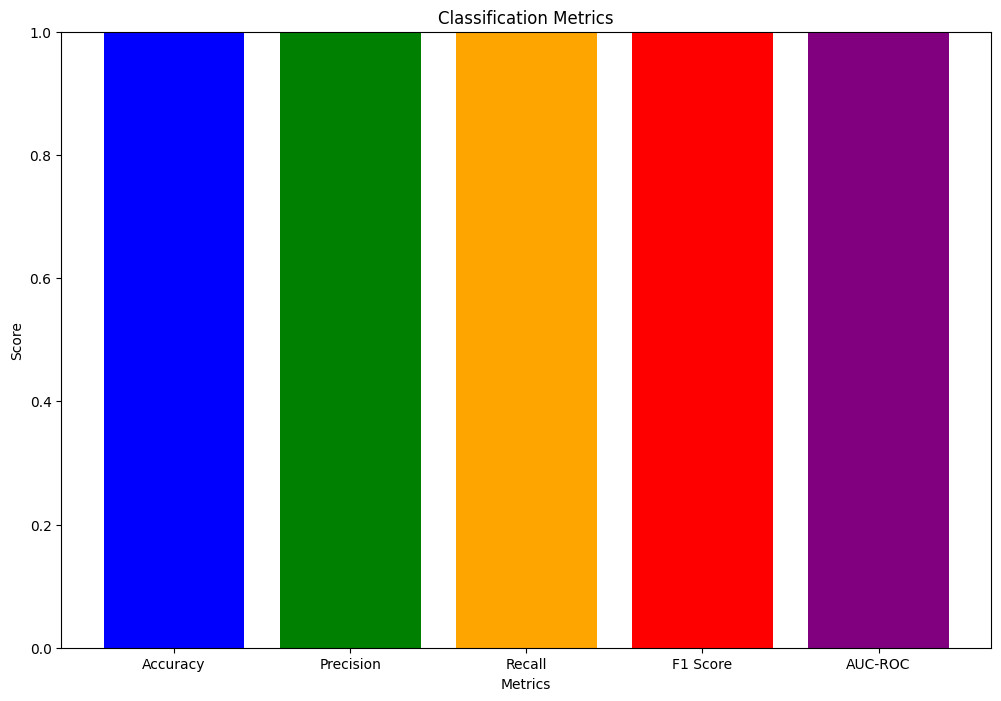

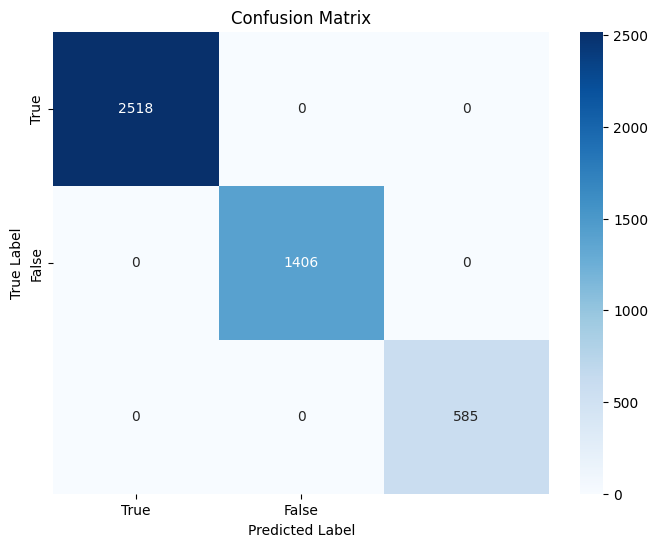

In [ ]:

from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, MultilayerPerceptronClassifier, LogisticRegression, NaiveBayes, LinearSVC, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.sql.functions import isnull, when, count, col,size, split
from pyspark.sql.types import DoubleType, StringType,IntegerType , StringType
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, jaccard_score
from pyspark.ml import Pipeline



class StudentDataClassifier:
    def __init__(self, spark_master="local", app_name="Student Data"):
        # Create a Spark Session
        self.spark = SparkSession.builder \
            .master(spark_master) \
            .appName(app_name) \
            .getOrCreate()

    def read_dataset(self, file_path):
        # Read dataset
        df = (self.spark.read
              .format("csv")
              .option("header", "true")
              .load(file_path))

        return df

    def select_columns(self, df):

        # Filter out rows where final_result is 'Withdrawn'
        df = df.filter(col('final_result') != 'Withdrawn')

        # Select specific columns and cast to the appropriate data type
        dataset = df.select(
            # col('code_module'),
            # col('code_presentation'),
            # col('id_student').cast('int'),
            col('gender'),
            col('highest_education'),
            # col('region'),
            # col('imd_band'),
            col('age_band'),
            col('num_of_prev_attempts').cast('int'),
            # col('studied_credits').cast('int'),
            col('disability').cast('int'),
            # col('date_registration').cast('int'),
            # col('date_unregistration').cast('int'),
            col('Assessment_count').cast('int'),
            # col('TMA_count').cast('int'),
            # col('CMA_count').cast('int'),
            # col('Exam_count').cast('int'),
            # col('TMA_Total_score').cast('int'),
            # col('CMA_Total_score').cast('int'),
            # col('Exam_score').cast('int'),
            # col('total_assessment_score').cast('int'),
            col('Submitted_Assessments').cast('int'),
            col('Not_submitted_Assessments').cast('int'),
            # col('Total_Assessments_score_100').cast('int'),
            # col('Average_Assessment_score').cast('double'),
            # col('Total_Mark').cast('double'),
            col('Total_resources').cast('int'),
            col('Total_clicks').cast('int'),
            col('final_result')
        )

        return dataset

    def handle_missing_values(self, dataset):
        # Impute missing values with mean for numerical columns
        numerical_cols = dataset.columns
        for column_name in numerical_cols:
            mean_val = dataset.agg({column_name: 'mean'}).collect()[0][0]
            dataset = dataset.withColumn(column_name, when(col(column_name).isNotNull(), col(column_name)).otherwise(mean_val))

        # # Impute missing values with the most frequent value for categorical columns
        # categorical_cols = ['gender', 'highest_education', 'region', 'imd_band', 'age_band', 'final_result']
        # for column_name in categorical_cols:
        #     mode_val = dataset.groupBy(column_name).count().sort(col("count").desc()).first()[column_name]
        #     dataset = dataset.withColumn(column_name, when(col(column_name).isNotNull(), col(column_name)).otherwise(mode_val))

        return dataset

    def convert_categorical_to_numeric(self, dataset):
        # Convert specific categorical variables to numeric using StringIndexer
        categorical_cols = ['gender', 'highest_education', 'region', 'imd_band', 'age_band', 'final_result']
        index_columns = []
        for column_name in categorical_cols:
            if column_name not in dataset.columns:
                continue
            indexer = StringIndexer(inputCol=column_name, outputCol=f'{column_name}_index', handleInvalid='keep')
            dataset = indexer.fit(dataset).transform(dataset)
            index_columns.append(f'{column_name}_index')

        # Drop the original categorical columns
        dataset = dataset.drop(*categorical_cols)

        return dataset

    def convert_to_numeric(self,df, numeric_cols):
        for col in numeric_cols:
            df = df.withColumn(col, df[col].cast(IntegerType()))
            df = df.na.fill(0)
        return df

    def feature_engineering(self, dataset):
        # Assemble features with VectorAssembler
        required_features = [col_name for col_name in dataset.columns if col_name != 'final_result']
        assembler = VectorAssembler(inputCols=required_features, outputCol='features')
        transformed_data = assembler.transform(dataset)
        return transformed_data

    def split_data(self, transformed_data, split_ratio=[0.8, 0.2]):
        # Split dataset into train and test
        training_data, test_data = transformed_data.randomSplit(split_ratio)
        print("Number of train samples: " + str(training_data.count()))
        print("Number of test samples: " + str(test_data.count()))
        return training_data, test_data

    def train_model(self, training_data):

        # # Train RandomForestClassifier model for multiclass classification
        classifier = RandomForestClassifier(labelCol='final_result_index', featuresCol='features', maxDepth=5)
        model = classifier.fit(training_data)

        # # classifier = DecisionTreeClassifier(labelCol='final_result_index', featuresCol='features', maxDepth=5)
        #model = classifier.fit(training_data)


        # # Create the MultilayerPerceptronClassifier and modelDefine the layers for the neural network
        # input_layer = len(training_data.select('features').first()[0])
        # output_layer = len(training_data.select('final_result_index').distinct().collect())
        # layers = [input_layer, 10, 5, output_layer]  # You can adjust the number of nodes in each layer as needed
        # classifier = MultilayerPerceptronClassifier(labelCol='final_result_index', featuresCol='features', layers=layers, blockSize=128, seed=1234)
        # model = classifier.fit(training_data)

        # Train LogisticRegression model for multiclass classification
        # classifier = LogisticRegression(labelCol='final_result_index', featuresCol='features', maxIter=10, regParam=0.3, elasticNetParam=0.8)
        # model = classifier.fit(training_data)

        # # Train NaiveBayes model for multiclass classification
        # # classifier = NaiveBayes(labelCol='final_result_index', featuresCol='features', smoothing=1.0, modelType='multinomial')

        # # Train LinearSVC model for multiclass classification
        # lsvc = LinearSVC(labelCol='final_result_index', featuresCol='features', maxIter=10, regParam=0.1)

        # # Create a pipeline with the classifier
        # pipeline = Pipeline(stages=[lsvc])

        # # Train the model
        # model = pipeline.fit(training_data)
        return model


    def evaluate_model(self, model, test_data):
        # Evaluate model
        predictions_test = model.transform(test_data)

        # Classification metrics
        evaluator_accuracy = MulticlassClassificationEvaluator(labelCol='final_result_index', metricName='accuracy')
        evaluator_precision = MulticlassClassificationEvaluator(labelCol='final_result_index', metricName='weightedPrecision')
        evaluator_recall = MulticlassClassificationEvaluator(labelCol='final_result_index', metricName='weightedRecall')
        evaluator_f1 = MulticlassClassificationEvaluator(labelCol='final_result_index', metricName='f1')

        # Accuracy
        accuracy = evaluator_accuracy.evaluate(predictions_test)
        print(f"Accuracy: {accuracy}")

        # Precision
        precision = evaluator_precision.evaluate(predictions_test)
        print(f"Precision: {precision}")

        # Recall
        recall = evaluator_recall.evaluate(predictions_test)
        print(f"Recall: {recall}")

        # F1 Score
        f1 = evaluator_f1.evaluate(predictions_test)
        print(f"F1 Score: {f1}")

        # Jaccard Similarity
        true_labels = predictions_test.select('final_result_index').rdd.flatMap(lambda x: x).collect()
        predicted_labels = predictions_test.select('prediction').rdd.flatMap(lambda x: x).collect()

        jaccard_similarity = jaccard_score(true_labels, predicted_labels, average='micro')
        print(f"Jaccard Similarity: {jaccard_similarity}")

        # Confusion matrix
        cm = confusion_matrix(true_labels, predicted_labels)
        print("Confusion Matrix:")
        print(cm)

        # Classification report
        class_report = classification_report(true_labels, predicted_labels)
        print("Classification Report:")
        print(class_report)

        # Visual representation
        self.plot_metrics(accuracy, precision, recall, f1, jaccard_similarity)

        # Visual representation of confusion matrix
        self.plot_confusion_matrix(cm)


    def plot_metrics(self, accuracy, precision, recall, f1, roc_auc):
        # Plotting various classification metrics
        metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC']
        metrics_values = [accuracy, precision, recall, f1, roc_auc]

        plt.figure(figsize=(12, 8))
        plt.bar(metrics_names, metrics_values, color=['blue', 'green', 'orange', 'red', 'purple'])
        plt.title('Classification Metrics')
        plt.xlabel('Metrics')
        plt.ylabel('Score')
        plt.ylim([0, 1])  # Assuming scores are between 0 and 1
        plt.show()

    def plot_confusion_matrix(self, cm):
        # Plotting confusion matrix as a heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['True', 'False'], yticklabels=['True', 'False'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

    def plot_accuracy(self, accuracy):
        # Plotting accuracy
        plt.figure(figsize=(8, 6))
        plt.bar(['Accuracy'], [accuracy], color='blue')
        plt.title('Model Accuracy')
        plt.xlabel('Metrics')
        plt.ylabel('Accuracy')
        plt.ylim([0, 1])  # Assuming accuracy is between 0 and 1
        plt.show()

if __name__ == "__main__":
    # Create an instance of StudentDataClassifier
    student_data_classifier = StudentDataClassifier()

    # Set the path to the Student Data dataset
    dataset_path = "/content/drive/My Drive/MalmoMsc/CapstoneProject/DataSet/train.v3.csv"  # Replace with the actual path

    # Read and preprocess the dataset
    df = student_data_classifier.read_dataset(dataset_path)
    print('read_dataset')
    # df.show()

    dataset = student_data_classifier.select_columns(df)
    print('select_columns')
    # dataset.show()

    columns = ['Total_resources','Total_clicks'] # 'Total_Mark', 'total_assessment_score','Total_Assessments_score_100','Average_Assessment_score',
    dataset = student_data_classifier.convert_to_numeric(dataset,columns)
    print('convert_to_numeric')
    # dataset.show()

    dataset = student_data_classifier.handle_missing_values(dataset)
    # dataset.show()
    dataset = student_data_classifier.convert_categorical_to_numeric(dataset)
    dataset.show()

    transformed_data = student_data_classifier.feature_engineering(dataset)
    print('feature_engineering')
    transformed_data.show()

    # # Function to check if features length is more than 3
    # def check_features_length(df):
    #     for row in df.rdd.collect():
    #         features_length = len(row.features)
    #         if features_length > 3:
    #             print(f"Row {row['features']}: Features length is more than 3")

    # Example usage
    # check_features_length(transformed_data)


    # Split the dataset
    training_data, test_data = student_data_classifier.split_data(transformed_data)

    # Train and evaluate the model
    model = student_data_classifier.train_model(training_data)
    student_data_classifier.evaluate_model(model, test_data)
  # #  try:   except Exception as e:
  #       print(f"An error occurred: {str(e)}")
